# Accuracy Method

Many prior examples of queries used comparisons of the actual values to the computed differentially private values. Intuitively, we assessed the quality of our results by visually inspecting the proximity of the actual values to the differentially private outputs. Moreover, comparing one DP release to the true value is a comparison with exactly 1 draw from a random variable. One may be "lucky" and get a release that is much more accurate than usual, or "unlucky" and get a release that is much less accurate than usual.

However, this approach isn't concrete since interpretations can vary widely on scale, type of visualization, and other factors. A more objective way to evaluate differentially private outputs is by using the `accuracy` method. 

With synthetic data a comparison with the "true" value is possible. However, this is not possible with real data. If the analysis plan is influenced by the actual data, it's a privacy leak. 


In this notebook, we will: 
- Explain the purpose and the application of the `accuracy` method. 
- Clarify how to interpret the results of the `accuracy` method. 

In [1]:
import opendp.prelude as dp
import polars as pl 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

dp.enable_features("contrib")

In [2]:
# Fetch and download data. 
!curl "https://github.com/opendp/dp-test-datasets/blob/master/data/sample_FR_LFS.csv.zip?raw=true" -L -o data.zip
!unzip data.zip
df = pl.scan_csv("sample_FR_LFS.csv", ignore_errors=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5933k  100 5933k    0     0  1007k      0  0:00:05  0:00:05 --:--:-- 1117k   0   992k      0  0:00:05  0:00:05 --:--:-- 1114k
Archive:  data.zip
  inflating: sample_FR_LFS.csv       
  inflating: __MACOSX/._sample_FR_LFS.csv  


In [3]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=3,
    margins={
        ("YEAR", "QUARTER",): dp.Margin(public_info="keys", max_partition_length=60_000_000, max_partition_contributions=1),
        (): dp.Margin(max_partition_length=60_000_000),
    },
)

We will use the same query we began with in [Part 1](http://example.com/TODO): a count query for each year and quarter.

In [4]:
# Compute dp values. 

#Save lazy query for accuracy method later on. 
dp_query = (context.query().
            group_by(["YEAR","QUARTER"]).
            agg(
                pl.len().
                dp.noise().
                alias("DP")
                )
    )       

dp_values = dp_query.sort(["YEAR","QUARTER"]).release().collect()

dp_values

YEAR,QUARTER,DP
i64,i64,u32
2004,1,4182
2004,2,4166
2004,3,4011
2004,4,4112
2005,1,4073
…,…,…
2012,4,6315
2013,1,6267
2013,2,5834


In [5]:
# Compute actual values. 
actual_values = (df.
                 group_by(["YEAR","QUARTER"]).
                 agg(
                     pl.len().
                     alias("Actual")
                     )
                ).sort(["YEAR","QUARTER"]).collect()
actual_values

YEAR,QUARTER,Actual
i64,i64,u32
2004,1,4200
2004,2,4180
2004,3,4054
2004,4,4057
2005,1,4175
…,…,…
2012,4,6392
2013,1,6267
2013,2,5864


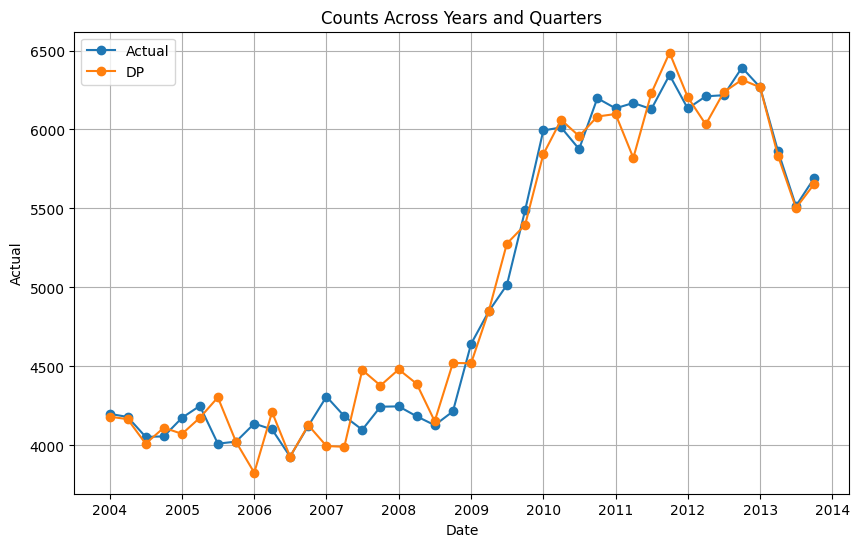

In [6]:
# Join dataframes. 
all_df = dp_values.join(actual_values, on=['YEAR', 'QUARTER'])
all_df = all_df.with_columns(
    pl.format("{}-Q{}", pl.col("YEAR"), pl.col("QUARTER")).alias("Year-Quarter")
)

# Convert to date time format for line plot. 
all_df = all_df.with_columns(
    pl.col("Year-Quarter").map_elements(lambda x: np.datetime64(pd.Period(x, freq='Q').to_timestamp())).alias("Date")
)

# Plotting.
dates = all_df.select(pl.col("Date")).to_numpy().flatten()
actual_vals = all_df.select(pl.col("Actual")).to_numpy().flatten()
dp_vals = all_df.select(pl.col("DP")).to_numpy().flatten()


plt.figure(figsize=(10, 6))
plt.plot(dates, actual_vals, marker='o', label="Actual")
plt.plot(dates, dp_vals, marker='o', label="DP")
plt.title('Counts Across Years and Quarters')
plt.xlabel('Date')
plt.ylabel('Actual')
plt.grid(True)
plt.legend()
plt.show()

It appears the differentially private values can vary significantly higher or lower for particular quarter and year combinations. However, on average, the differentially private values follow a similar trend as the actual values. 

To evaluate this using the `accuracy,` method, apply it to the naive query itself before you apply `release()` and `collect` on it. 

The `accuracy` method has one optional parameter: alpha, which is the optional statistical significance to use to compute accuracy. If you don't specify alpha, you'll still get a table, but it won't have an accuracy value. In this case, we will specify alpha to be 0.05. 

In [8]:
import polars as pl
data = pl.LazyFrame([pl.Series("convicted", [0, 1, 1, 0, 1] * 50, dtype=pl.Int32)])

context = dp.Context.compositor(
data=data,
privacy_unit=dp.unit_of(contributions=1),
privacy_loss=dp.loss_of(epsilon=1.0),
split_evenly_over=1,
margins={(): dp.Margin(max_partition_length=1000)},
)

query = context.query().select(
pl.len().dp.noise(), 
pl.col("convicted").fill_null(0).dp.sum((0, 1))
)

query.accuracy(alpha=.05) 

AttributeError: 'LazyFrameQuery' object has no attribute 'accuracy'

In [9]:
from opendp.accuracy import describe_polars_measurement_accuracy
describe_polars_measurement_accuracy(query.resolve(), 0.5)

ImportError: cannot import name 'describe_polars_measurement_accuracy' from 'opendp.accuracy' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/opendp/accuracy.py)

In [7]:
accuracy_table = dp_query.accuracy(0.05)
accuracy_table

AttributeError: 'LazyFrameQuery' object has no attribute 'accuracy'

Let's interpret each column in the output: 
- `column`: Specifies the alias of the column with the differentially private values. 
- `aggregate`: Specifies the aggregate function used. 
- `distribution`: Specifies the distribution used to add noise. 
- `scale`: The scale parameter used in the Laplace distribution determines the spread and variability in the distribution. A larger scale parameter results in a more spread-out distribution with higher variance. 

To interpret accuracy, we can use the following helper function. 

In [ ]:
def interpret_accuracy(table, alpha):
    return (
        f"When the {table['distribution'].item()} scale is {table['scale'].item()}, \n"
        f"the DP estimate differs from the true value by no more than {table['accuracy'].item()} \n"
        f"at a statistical significance level alpha of {alpha}, \n"
        f"or with (1 - {alpha})100% = {(1 - alpha) * 100}% confidence."
    )

interp = interpret_accuracy(accuracy_table,
                            alpha=.05)
print(interp)

When the Integer Laplace scale is 360.0000000000001, 
the DP estimate differs from the true value by no more than 1078.9632712573266 
at a statistical significance level alpha of 0.05, 
or with (1 - 0.05)100% = 95.0% confidence.


Essentially, when we use a noise level of 360, we will be 95% confident that the differentially private value we get will be within 1079 units of the true value.

## Conclusion

In this notebook, we learned what the purpose of the `accuracy` method is, how to use it, and how to interpret it. This is just one of the [evaluation methods](http://example.com/TODO) users can employ to gauge utility. 